## Goal
Here we have four dog hound pics in ~/data/raw_dog. Let's see if we can use MXNet to determine which dogs are the most similar! We'll convert each image to a vector and compute the cosine similarieties:

similarity = np.dot(u,v) / (np.linalg.norm(u) * np.linalg.norm(v))

## Steps:
1. Load in image as mxnet NDarry
2. Resize and preprocess image
3. Load pretrained model
4. Get Feature Array
5. Put it all together

In [1]:
import mxnet as mx
from mxnet.gluon.model_zoo import vision
import os
import numpy as np
import glob
import pandas as pd
#from scipy.spatial.distance import cosine
from IPython.display import Image 

# set the context on CPU, switch to GPU if there is one available
ctx = mx.cpu()

### 1. Load in image as mxnet NDarry

In [2]:
fn = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw_dog', 'dog1.jpg')
os.path.isfile(fn)
image = mx.image.imdecode(open(fn, 'rb').read()).astype(np.float32)
print(image.shape)

(500, 375, 3)


### 2. Resize and preprocess image

In [3]:
#From  https://discuss.mxnet.io/t/gluon-pretrained-model-layer-access-and-usage/772/2
resized = mx.image.resize_short(image, 224) #minimum 224x224 images
cropped, crop_info = mx.image.center_crop(resized, (224, 224))
normalized = mx.image.color_normalize(cropped/255,
                                      mean=mx.nd.array([0.485, 0.456, 0.406]),
                                      std=mx.nd.array([0.229, 0.224, 0.225])) 
# the network expect batches of the form (N,3,224,224)
flipped_axis = normalized.transpose((2,0,1))  # Flipping from (224, 224, 3) to (3, 224, 224)
batchified = flipped_axis.expand_dims(axis=0) # change the shape from (3, 224, 224) to (1, 3, 224, 224)


### 3. Load Pretrained Model

In [4]:
%time densenet = vision.densenet201(pretrained=True)
type(densenet)

Wall time: 648 ms


mxnet.gluon.model_zoo.vision.densenet.DenseNet

### 4. Get Feature Array

In [5]:
densenet.features(batchified)[0]


[3.0087696e-05 7.8085298e-04 1.1127489e-03 ... 1.1631262e+00 5.1810938e-01
 2.5483578e-01]
<NDArray 1920 @cpu(0)>

### 5. Put it all Together

In [6]:
df = pd.DataFrame()
df['fn'] = None
df['vector'] = None
fns = glob.iglob(os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw_dog','*'))
for index, fn in enumerate(fns):
    print('Processing: ',fn)
    df.loc[index,'fn'] = fn
    image = mx.image.imdecode(open(fn, 'rb').read()).astype(np.float32)
    resized = mx.image.resize_short(image, 224) #minimum 224x224 images
    cropped, crop_info = mx.image.center_crop(resized, (224, 224))
    normalized = mx.image.color_normalize(cropped/255,
                                          mean=mx.nd.array([0.485, 0.456, 0.406]),
                                          std=mx.nd.array([0.229, 0.224, 0.225])) 
    # the network expect batches of the form (N,3,224,224)
    flipped_axis = normalized.transpose((2,0,1))  # Flipping from (224, 224, 3) to (3, 224, 224)
    batchified = flipped_axis.expand_dims(axis=0) # change the shape from (3, 224, 224) to (1, 3, 224, 224)
    df.loc[index,'vector'] = densenet.features(batchified)[0]
fn_save = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed','0.0.1-whs-dogVectors.json')
try:
    os.mkdir(os.path.dirname(fn_save))
except:
    pass
df.to_pickle(fn_save)
df.tail()

Processing:  C:\Users\willsolo\Documents\GitHub\ImageComparison\data\raw_dog\dog1.jpg
Processing:  C:\Users\willsolo\Documents\GitHub\ImageComparison\data\raw_dog\dog2.jpg
Processing:  C:\Users\willsolo\Documents\GitHub\ImageComparison\data\raw_dog\dog3.jpg
Processing:  C:\Users\willsolo\Documents\GitHub\ImageComparison\data\raw_dog\dog4.jpg


,fn,vector
0,C:\Users\willsolo\Documents\GitHub\ImageCompar...,"[[[\n[3.0087696e-05]\n<NDArray 1 @cpu(0)>]], [..."
1,C:\Users\willsolo\Documents\GitHub\ImageCompar...,"[[[\n[2.3763136e-05]\n<NDArray 1 @cpu(0)>]], [..."
2,C:\Users\willsolo\Documents\GitHub\ImageCompar...,"[[[\n[7.001918e-05]\n<NDArray 1 @cpu(0)>]], [[..."
3,C:\Users\willsolo\Documents\GitHub\ImageCompar...,"[[[\n[0.00010705]\n<NDArray 1 @cpu(0)>]], [[\n..."


In [7]:
df = pd.read_pickle(fn_save)
labels = [df['fn'].loc[index].split('\\')[-1] for index in range(df.count()[0])]
df_cross = pd.DataFrame(columns=labels, index=labels)
for index in range(df.count()[0]):
    for sub_index in range(df.count()[0]):
        u = df['vector'].loc[index].asnumpy()
        v = df['vector'].loc[sub_index].asnumpy()
        label1 = df['fn'].loc[index].split('\\')[-1]
        label2 = df['fn'].loc[sub_index].split('\\')[-1]
        df_cross[label1][label2] = np.dot(u,v) / (np.linalg.norm(u) * np.linalg.norm(v))
df_cross.tail()

,dog1.jpg,dog2.jpg,dog3.jpg,dog4.jpg
dog1.jpg,1,0.486458,0.432894,0.465906
dog2.jpg,0.486458,1,0.677692,0.41852
dog3.jpg,0.432894,0.677692,1,0.540258
dog4.jpg,0.465906,0.41852,0.540258,1


#### Looks like our model is saying dog2 and dog3 are the same. Let's compare: 

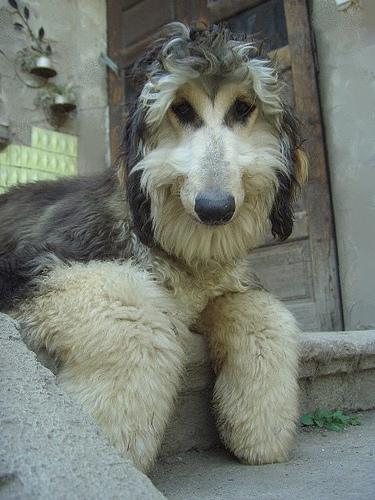

In [8]:
Image(filename=df.fn[0])

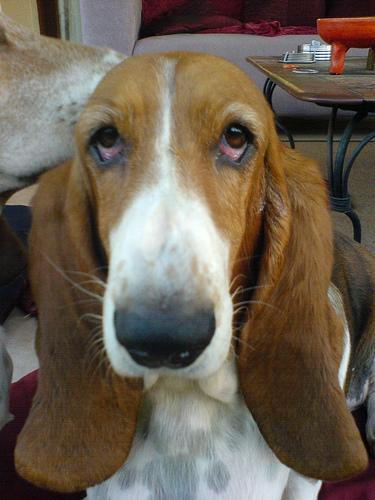

In [9]:
Image(filename=df.fn[1])

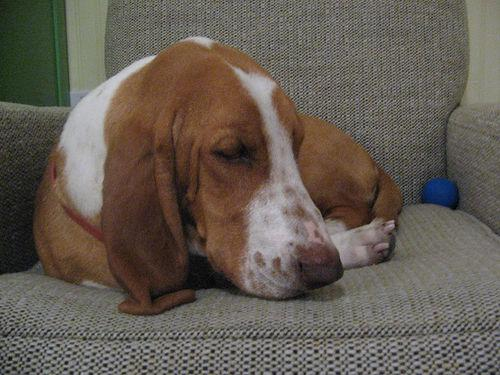

In [10]:
Image(filename=df.fn[2])

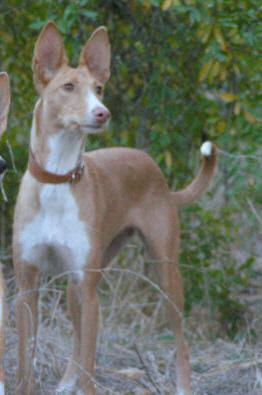

In [11]:
Image(filename=df.fn[3])

### Dog 2 and 3 are definately most similar! Looks like its Working!